In [131]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


# metrics evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# To standardise data
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
#from imblearn.under_sampling import RandomUnderSampler

# For train/test split
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold as vt
#from imblearn.pipeline import make_pipeline, Pipeline
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [89]:
#%reset

In [91]:
#import CSVs, assign headers and remove quotations from column headers
white_wine = pd.read_csv(r'C:\Users\Killian\Projects\Wine analysis\Wine data\winequality-white.csv', sep=';',header=0, engine='python')

In [92]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low'
if value <= 4 else 'medium-low'
if value == 5 else 'medium' if value == 6 else 'medium-high' if value == 7 else 'high')

In [93]:
wine = []
for column in white_wine.columns[0:-2]:
        wine.append([white_wine[column].astype(float).skew().round(2), white_wine[column].astype(float).kurt().round(2)])

wine_stats = pd.DataFrame(wine, index=[white_wine.columns[0:-2]], columns=['Skewness', 'Kurtosis'])
display(wine_stats)

,Skewness,Kurtosis
fixed acidity,0.65,2.17
volatile acidity,1.58,5.09
citric acid,1.28,6.17
residual sugar,1.08,3.47
chlorides,5.02,37.56
free sulfur dioxide,1.41,11.47
total sulfur dioxide,0.39,0.57
density,0.98,9.79
pH,0.46,0.53
sulphates,0.98,1.59


In [94]:

white_wine["label"].value_counts()

medium         2198
medium-low     1457
medium-high     880
low             183
high            180
Name: label, dtype: int64

In [95]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <=6 else 'high')
white_wine.head()
white_wine["label"].value_counts()

medium    2198
low       1640
high      1060
Name: label, dtype: int64

In [96]:
features=white_wine.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [101]:
#white_label = LabelEncoder()
white_wine['category'] = white_wine.label.map({"low" : "0", "medium" : "1", "high" : "2"}).astype('int')
white_wine= white_wine.drop(columns="quality")
print(white_wine.category.value_counts())
white_wine.category.dtypes
#As seen from previous results, Medium = 2, Low = 1, High = 0.
#Can't use OrdinalEncoder as it is 1D data. Ordinal Encoder is used on 2D array. 

1    2198
0    1640
2    1060
Name: category, dtype: int64


dtype('int32')

In [ ]:
#white_label = OrdinalEncoder(categories=[['low', 'medium', 'high']])
#white_wine['label'].values.reshape(-1,1)
#white_wine['category'] = white_label.fit_transform(white_wine['label'])
#white_wine['category'].value_counts()

In [102]:
white_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label,category
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,medium,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,low,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,medium,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,high,2
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,medium,1


In [103]:
#Create target and features for algorithm
#Full feature list for ease of access while doing Backward Eliination and refining model: 'fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 
# 'sulphates','citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'
X = white_wine.copy()
y = X.category #target
X =white_wine.drop(columns=['category', 'label']) # features we want to test, except target and correlated values, i.e. Quality and Label. 
# Final list will include features removed due to results from Backward Elimination.
X_list = list(X.columns)
print(X.columns.tolist())
print(y)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
0       1
1       1
2       1
3       1
4       1
       ..
4893    1
4894    0
4895    1
4896    2
4897    1
Name: category, Length: 4898, dtype: int32


In [127]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #, stratify=y) # random state controls the shuffling applied before the split. 42 is a popular random seed.
#stratification ensures equitable split of low/medium/high quality across training and test data
print(Counter(y_train), Counter(y_test))
print('Features:', list(X))

Counter({1: 1530, 0: 1167, 2: 731}) Counter({1: 668, 0: 473, 2: 329})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [132]:
# Because of the skewedness of the model, with many outliers, it does not seem appropriate to use either normalisation or
# standardisation. I will be applying a tree based algorithm which is insensitive to the scale of features as it splits
# nodes based on single features. 

#Below I am testing to make sure the shapes are as predicted (column numbers match)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (3428, 11)
Training Labels Shape: (3428,)
Testing Features Shape: (1470, 11)
Testing Labels Shape: (1470,)


In [48]:
# Instantiate model with 1000 decision trees
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
#check parameters to ensure that all variables accounted for and to keep in mind anything to change next time. 
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [49]:
# Train the model on training data
model = rfc.fit(X_train, y_train);

In [50]:
pred_rfc = rfc.predict(X_test) #The predicted class of an input sample is a vote by the trees in the forest, weighted by their probability estimates. 
#That is, the predicted class is the one with highest mean probability estimate across the trees.
print(pred_rfc.shape)
print(y_test.shape)

(980,)
(980,)


In [51]:
#Import scikit-learn metrics module for accuracy calculation
# Model Accuracy, how often is the classifier correct?

Score = round(accuracy_score(y_test, pred_rfc), 4)*100
print("Accuracy:", Score, "%")

Accuracy: 73.57000000000001 %


In [52]:
print(cross_val_score(model, X, y, cv=3))

[0.52357624 0.58358849 0.54779412]


In [55]:
#Its validation performance, measured via the score, is significantly larger than the chance level. 
# This makes it possible to use the permutation_importance function to probe which features are most predictive. 
# The scores represent the predictive quality of the feature.

#Features that are important on the training set but not on the held-out set might cause the model to overfit.

r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

#score = ["r2", "neg_mean_absolute_percentage_error", "neg_mean_squared_error"]
#r_multi = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0, scoring=[score])

#for metric in r_multi:
#    print(f"{metric}")
#    r = r_multi[metric]

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
        f"{r.importances_mean[i]*100:.3f}", "%",
        f" +/- {r.importances_std[i]*100:.3f}", "%")

alcohol  14.864 %  +/- 1.280 %
volatile acidity 8.408 %  +/- 0.862 %
free sulfur dioxide 4.782 %  +/- 0.683 %
chlorides 3.796 %  +/- 0.987 %
pH       3.207 %  +/- 0.552 %
density  2.912 %  +/- 0.746 %
total sulfur dioxide 2.704 %  +/- 0.668 %
citric acid 2.432 %  +/- 0.765 %
residual sugar 2.085 %  +/- 0.598 %
sulphates 1.833 %  +/- 0.520 %
fixed acidity 1.422 %  +/- 0.541 %


NameError: name 'forest_importances' is not defined

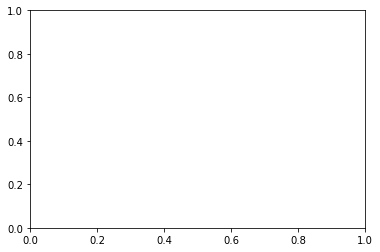

In [25]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [56]:
#Poor agreement = Less than 0.20 (including negative numbers)
#Fair agreement = 0.20 to 0.40
#Moderate agreement = 0.40 to 0.60
#Good agreement = 0.60 to 0.80
#Very good agreement = 0.80 to 1.00

# Cohen’s Kappa is a statistical measure that is used to measure the reliability of 
# two raters who are rating the same quantity and identifies how frequently the raters are in agreement. 


kappa = cohen_kappa_score(pred_rfc, y_test)
print("Cohen-Kappa score:", round(kappa, 2))

Cohen-Kappa score: 0.58


In [57]:
print(classification_report(y_test, pred_rfc, target_names=["low","medium", "high"]))

              precision    recall  f1-score   support

         low       0.81      0.68      0.74       227
      medium       0.76      0.74      0.75       321
        high       0.69      0.76      0.72       432

    accuracy                           0.74       980
   macro avg       0.75      0.73      0.74       980
weighted avg       0.74      0.74      0.74       980



In [105]:
print(y_test)

4666    1
3662    1
483     1
4417    2
1765    1
       ..
1409    2
309     2
351     0
3389    0
1840    1
Name: category, Length: 980, dtype: int32


In [76]:
print("Confusion matrix:")
labels = np.unique(y_test)
a = confusion_matrix(y_test, pred_rfc, labels=labels)
a = pd.DataFrame(a, index=labels, columns=labels)
display(a)

Confusion matrix:


,0,1,2
0,155,5,67
1,3,239,79
2,34,71,327


In [78]:
#show feature importance

for i in zip(X_list, rfc.feature_importances_):
    print (i)

#a = np.array([X_list,rfc.feature_importances_])
#print(a.T)

('fixed acidity', 0.07118132741173143)
('volatile acidity', 0.10372862559696565)
('citric acid', 0.0799732830827334)
('residual sugar', 0.08592049086293027)
('chlorides', 0.08407672016098995)
('free sulfur dioxide', 0.09542268836276609)
('total sulfur dioxide', 0.08682833767470706)
('density', 0.1092897921625713)
('pH', 0.08315730906188278)
('sulphates', 0.07480011735182895)
('alcohol', 0.1256213082708932)


In [81]:
important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)

print('5 most important features:')
{important_features_list[:5]}

5 most important features:


TypeError: unhashable type: 'list'

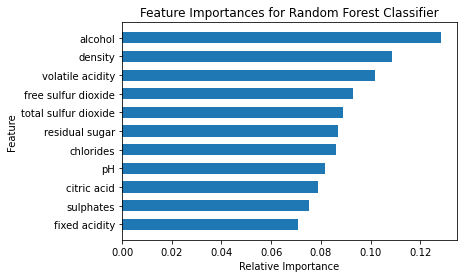

In [31]:
#'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'

importances = rfc.feature_importances_
rfc_feature_names, rfc_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'citric acid', 
'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
importances), key=lambda x: x[1]))
y_position = list(range(len(rfc_feature_names)))
plt.barh(y_position, rfc_feature_scores, height=0.6, align='center')
plt.yticks(y_position , rfc_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest Classifier')

In [76]:
rfc.plot_importance(white_wine, importance_type="weight")

AttributeError: 'RandomForestClassifier' object has no attribute 'plot_importance'

In [106]:
#Adding constant column of ones, mandatory for sm.OLS model
#The performance metric used here to evaluate feature performance is pvalue. 
# If the pvalue is above 0.05 then we remove the feature, else we keep it.

#DOES THIS REQUIRE DATA TO BE NORMALISED/STANDARDISED?? AS RESULTS DO NOT MATCH OTHER FEATURE IMPORTANCE EVALUATIONS
X_2 = sm.add_constant(X)
#Fitting sm.OLS model
model1 = sm.OLS(y,X_2).fit()
model1.pvalues.sort_values(ascending=False)

citric acid             5.574518e-01
chlorides               4.647950e-01
total sulfur dioxide    5.904894e-02
fixed acidity           2.586806e-04
free sulfur dioxide     5.975940e-06
pH                      7.024703e-11
sulphates               1.401996e-11
const                   6.805938e-12
density                 2.057222e-12
alcohol                 3.774184e-20
residual sugar          3.647661e-22
volatile acidity        1.372719e-53
dtype: float64

In [107]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['fixed acidity', 'volatile acidity', 'residual sugar', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [84]:
# train the model
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# predict and evaluate performance
pred_dtc = dtc.predict(X_test)

In [85]:
pred_dtc = dtc.predict(X_test)
print(pred_dtc.shape)
print(y_test.shape)

(980,)
(980,)


In [86]:
print(classification_report(y_test, pred_dtc, target_names=["low","medium", "high"]))
print("Accuracy score:", accuracy_score(y_test, pred_dtc))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_dtc))

kappa = cohen_kappa_score(pred_dtc, y_test)
print("Cohen-Kappa score:", kappa)

              precision    recall  f1-score   support

         low       0.60      0.70      0.65       227
      medium       0.70      0.66      0.68       321
        high       0.66      0.63      0.64       432

    accuracy                           0.66       980
   macro avg       0.65      0.66      0.66       980
weighted avg       0.66      0.66      0.66       980

Accuracy score: 0.6551020408163265
Confusion matrix:
[[159  14  54]
 [ 22 212  87]
 [ 82  79 271]]
Cohen-Kappa score: 0.46985483587010446


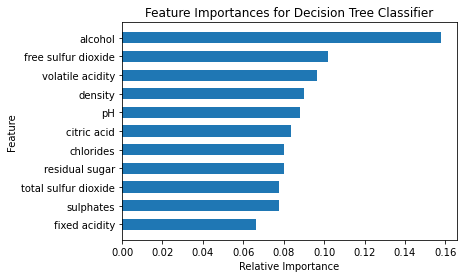

In [38]:
importances = dtc.feature_importances_
dtc_feature_names, dtc_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
importances), key=lambda x: x[1]))
y_position = list(range(len(dtc_feature_names)))
plt.barh(y_position, dtc_feature_scores, height=0.6, align='center')
plt.yticks(y_position , dtc_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree Classifier')

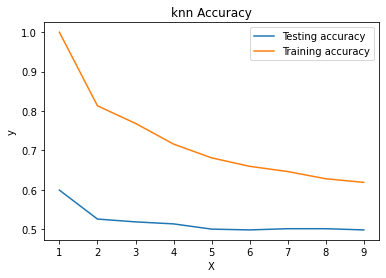

In [41]:
neighbors=np.arange(1,10)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i]=knn.score(X_train, y_train)
    test_accuracy[i]=knn.score(X_test, y_test)

plt.title("knn Accuracy")
plt.plot(neighbors, test_accuracy, label="Testing accuracy")
plt.plot(neighbors, train_accuracy, label="Training accuracy")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [42]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.5255102040816326


In [43]:
pred_knn = knn.predict(X_test)
print(pred_knn.shape)
print(y_test.shape)

(980,)
(980,)


In [44]:
print(classification_report(y_test, pred_knn, target_names=["low","medium", "high"]))
print("Accuracy score:", accuracy_score(y_test, pred_knn))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_knn))

kappa = cohen_kappa_score(pred_knn, y_test)
print("Cohen-Kappa score:", kappa)

              precision    recall  f1-score   support

         low       0.43      0.65      0.52       212
      medium       0.52      0.64      0.58       328
        high       0.65      0.38      0.48       440

    accuracy                           0.53       980
   macro avg       0.53      0.56      0.52       980
weighted avg       0.56      0.53      0.52       980

Accuracy score: 0.5255102040816326
Confusion matrix:
[[138  42  32]
 [ 60 211  57]
 [125 149 166]]
Cohen-Kappa score: 0.29661597732871514


In [45]:
#If you are set on using KNN though, then the best way to estimate feature importance is by 
# taking the sample to predict on, and computing its distance from each of its nearest neighbors 
# for each feature (call these neighb_dist). Then do the same computations for a few random points 
# (call these rand_dist) instead of the nearest neighbors. Then for each feature, you take the ratio 
# of neighb_dist / rand_dist, and the smaller the ratio, the more important that feature is.


importances = knn.feature_importances_
knn_feature_names, knn_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
importances), key=lambda x: x[1]))
y_position = list(range(len(knn_feature_names)))
plt.barh(y_position, knn_feature_scores, height=0.6, align='center')
plt.yticks(y_position , knn_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for KNeighbors Classifier')

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [128]:
# fit model to training data (firstly uing defaults)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
print(model) #See the parameters used 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)


In [129]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [130]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.41%
